In [1]:
#Import Libraries
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline



In [2]:
train = pd.read_csv("../data/train.csv",sep=",")
test = pd.read_csv("../data/test.csv",sep=",")

In [3]:
#Drop an extraneous column and determine the shape of the train data frame.
train=train.drop(['Unnamed: 0'], axis=1)
test=test.drop(['Unnamed: 0'], axis=1)


In [4]:
pd.set_option("display.max_columns", None)
train.head()

,Attrition,Age,DistanceFromHome,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,PerformanceRating,JobInvolvement,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age_Bin,Gender_Male,JobRole_Human_Resources,JobRole_Laboratory_Technician,JobRole_Manager,JobRole_Manufacturing_Director,JobRole_Research_Director,JobRole_Research_Scientist,JobRole_Sales_Executive,JobRole_Sales_Representative,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Education_2,Education_3,Education_4,Education_5,EducationField_Life_Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical_Degree,JobLevel_2,JobLevel_3,JobLevel_4,JobLevel_5,MaritalStatus_Married,MaritalStatus_Single,Department_Research_Development,Department_Sales,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3
0,0,22,6,108510,1.0,16,1.0,2,1,0,0,3,3,1.0,3.0,3.0,0.0,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False
1,0,33,2,87930,6.0,17,8.0,2,5,1,2,3,2,3.0,3.0,3.0,1.0,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False
2,0,42,2,45390,4.0,17,8.0,5,0,0,0,3,4,3.0,4.0,4.0,2.0,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,True,False,False,True,False,False,False,False,True,False,True,True,False,False
3,1,26,1,24260,1.0,13,1.0,3,1,0,0,4,3,2.0,3.0,1.0,0.0,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,True,False,False,False,False,True,False,True,False,False,False
4,0,40,2,27180,1.0,14,9.0,4,9,4,7,3,3,4.0,4.0,4.0,1.0,True,False,False,False,True,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False


## Correlation-Based Feature Selection

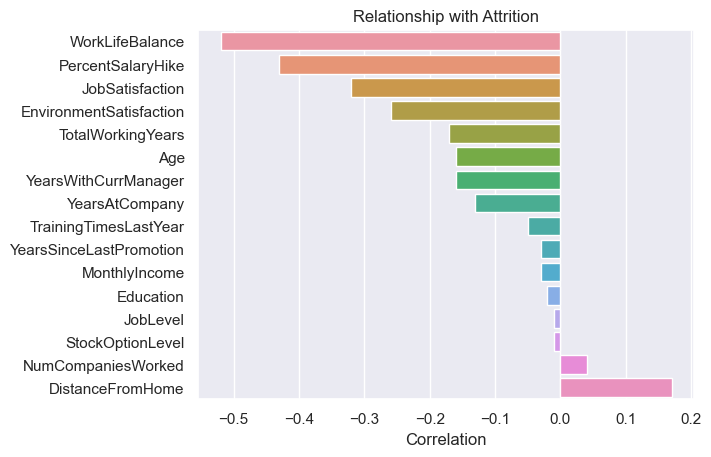

In [5]:
features = ['WorkLifeBalance', 'PercentSalaryHike', 'JobSatisfaction', 'EnvironmentSatisfaction', 'TotalWorkingYears', 'Age', 'YearsWithCurrManager',
    'YearsAtCompany', 'TrainingTimesLastYear', 'YearsSinceLastPromotion', 'MonthlyIncome', 'DistanceFromHome']

In [6]:
X_train = train.drop(columns = 'Attrition')
y_train = train['Attrition']

scaler = StandardScaler().set_output(transform = 'pandas').fit(X_train[features])
X_train_std = scaler.transform(X_train[features])

X_train_std.head()

,WorkLifeBalance,PercentSalaryHike,JobSatisfaction,EnvironmentSatisfaction,TotalWorkingYears,Age,YearsWithCurrManager,YearsAtCompany,TrainingTimesLastYear,YearsSinceLastPromotion,MonthlyIncome,DistanceFromHome
0,0.448161,0.743202,0.193042,-1.574223,-1.238640,-1.512954,-1.052884,-0.884216,-0.569374,-0.673786,0.999454,-0.398487
1,0.448161,0.962162,0.193042,0.327164,-0.287691,-0.300691,-0.452368,-0.183804,-0.569374,-0.337793,0.545452,-0.905815
2,1.460027,0.962162,1.238402,0.327164,-0.287691,0.691160,-1.052884,-1.059319,1.948677,-0.673786,-0.392994,-0.905815
3,-1.575571,0.086320,0.193042,-0.623530,-1.238640,-1.072131,-1.052884,-0.884216,0.269977,-0.673786,-0.859129,-1.032647
4,1.460027,0.305281,1.238402,1.277858,-0.151841,0.470749,1.048922,0.516608,1.109327,0.670183,-0.794713,-0.905815


In [7]:
# Standardize test data
X_test = test.drop(columns = 'Attrition')
y_test = test['Attrition']

X_test_std = scaler.transform(X_test[features])

In [8]:
# Function to grab odds ratios

def get_OR(model):

    # Build a data frame with odds ratios and their confidence intervals.
    odds_ratios = pd.DataFrame(
        {
            "OR": model.params,
            "Lower CI": model.conf_int()[0],
            "Upper CI": model.conf_int()[1],
        }
    )
    # Exponentiate the data frame
    odds_ratios = np.exp(odds_ratios)

    # Print the results
    # print(odds_ratios.sort_values('OR'))

    return (odds_ratios.sort_values('OR').round(3))

In [9]:
X_train_std  = sm.add_constant(X_train_std)
X_test_std  = sm.add_constant(X_test_std)

## Create baseline model based on only Initiative Options

In [10]:
log_reg_init = sm.Logit(y_train, X_train_std[['const', 'WorkLifeBalance', 'JobSatisfaction', 'EnvironmentSatisfaction', 'TrainingTimesLastYear', 'MonthlyIncome']]).fit()
print(log_reg_init.summary())

Optimization terminated successfully.
         Current function value: 0.325990
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 4850
Model:                          Logit   Df Residuals:                     4844
Method:                           MLE   Df Model:                            5
Date:                Thu, 11 Jan 2024   Pseudo R-squ.:                  0.5297
Time:                        12:32:15   Log-Likelihood:                -1581.1
converged:                       True   LL-Null:                       -3361.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0445      0.045     -0.984      0.325      -0.133   

In [11]:
get_OR(log_reg_init)

,OR,Lower CI,Upper CI
WorkLifeBalance,0.123,0.109,0.140
JobSatisfaction,0.408,0.370,0.449
EnvironmentSatisfaction,0.451,0.410,0.496
TrainingTimesLastYear,0.701,0.639,0.769
MonthlyIncome,0.909,0.833,0.994
const,0.956,0.875,1.045


## Extend model with high correlation features

In [12]:
features = ['const', 'WorkLifeBalance', 'PercentSalaryHike', 'JobSatisfaction', 'EnvironmentSatisfaction', 'TotalWorkingYears', 'Age', 'YearsWithCurrManager',
    'YearsAtCompany', 'TrainingTimesLastYear', 'YearsSinceLastPromotion', 'MonthlyIncome', 'DistanceFromHome']

log_reg_ext = sm.Logit(y_train, X_train_std[features]).fit()
print(log_reg_ext.summary())

Optimization terminated successfully.
         Current function value: 0.207585
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 4850
Model:                          Logit   Df Residuals:                     4837
Method:                           MLE   Df Model:                           12
Date:                Thu, 11 Jan 2024   Pseudo R-squ.:                  0.7005
Time:                        12:32:16   Log-Likelihood:                -1006.8
converged:                       True   LL-Null:                       -3361.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0527      0.058     -0.908      0.364      -0.166   

In [13]:
get_OR(log_reg_ext)

,OR,Lower CI,Upper CI
WorkLifeBalance,0.115,0.097,0.135
PercentSalaryHike,0.145,0.122,0.172
JobSatisfaction,0.375,0.331,0.424
EnvironmentSatisfaction,0.445,0.394,0.502
YearsWithCurrManager,0.500,0.416,0.601
Age,0.605,0.514,0.713
TrainingTimesLastYear,0.636,0.563,0.718
MonthlyIncome,0.820,0.731,0.920
YearsAtCompany,0.920,0.747,1.134
const,0.949,0.847,1.063


### Calculate change in odds

In [14]:
def change_in_odds(model):
    return (get_OR(model) - 1) * 100

odds_change = change_in_odds(log_reg_ext).reset_index().rename(columns = {'index': "Variable", "OR": 'Change in Odds'})
odds_change = odds_change[odds_change["Variable"] != 'const']
Initiative = {'Initiative Option': ['Yes', 'No', 'Yes',
       'Yes', 'No', 'No',
       'Yes', 'Yes', 'No',
       'No', 'No', 'No', 'No']}

odds_change['Initiative Option'] = pd.Series(Initiative['Initiative Option'])
odds_change

,Variable,Change in Odds,Lower CI,Upper CI,Initiative Option
0,WorkLifeBalance,-88.5,-90.3,-86.5,Yes
1,PercentSalaryHike,-85.5,-87.8,-82.8,No
2,JobSatisfaction,-62.5,-66.9,-57.6,Yes
3,EnvironmentSatisfaction,-55.5,-60.6,-49.8,Yes
4,YearsWithCurrManager,-50.0,-58.4,-39.9,No
5,Age,-39.5,-48.6,-28.7,No
6,TrainingTimesLastYear,-36.4,-43.7,-28.2,Yes
7,MonthlyIncome,-18.0,-26.9,-8.0,Yes
8,YearsAtCompany,-8.0,-25.3,13.4,No
10,TotalWorkingYears,5.6,-13.4,28.8,No


In [15]:
import matplotlib
matplotlib.rcParams['font.family'] = 'Verdana'
sns.set(style = 'whitegrid')

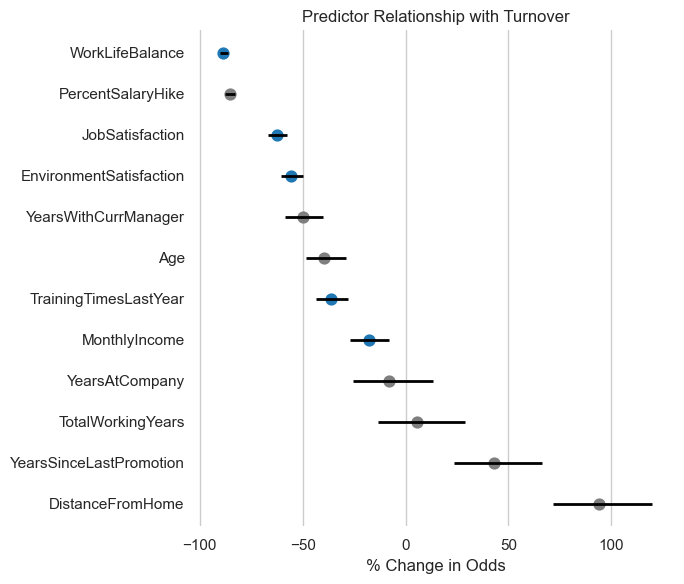

In [16]:
plt.figure(figsize=(7, 6))  # Adjust the width and height as needed



sns.pointplot(data = odds_change, x = 'Change in Odds', y = 'Variable', join = False, hue = 'Initiative Option', palette = ['tab:blue', 'tab:gray'], dodge = False, scale = 1)

plt.errorbar(y=odds_change['Variable'], x=odds_change['Change in Odds'],
 xerr=(odds_change['Change in Odds'] - odds_change['Lower CI'], odds_change['Upper CI'] - odds_change['Change in Odds']),
fmt='none', color='black', elinewidth = 2)  # Plot the error bars

plt.ylabel(None)
plt.xlabel('% Change in Odds')

plt.title('Predictor Relationship with Turnover')
plt.tight_layout()

# Remove top and right spines
sns.despine(right=True, top=True, left = True, bottom = True)  # Set right and top to True to remove the corresponding spines
plt.legend().remove()

plt.show()


This means that each additional increase (standard deviation) of one WorkLifeBalance_sd is associated with an 88.3% (86.5-90.3)decrease in the odds of a worker leaving the company.


## Evaluate Model Performance

In [17]:
# Train
y_pred_train = log_reg_ext.predict(X_train_std)
prediction_train = list(map(round, y_pred_train))

# Test
y_pred_test = log_reg_ext.predict(X_test_std)
prediction_test = list(map(round, y_pred_test))


In [18]:
y_pred_test.round().value_counts()

0.0    1141
1.0     288
Name: count, dtype: int64

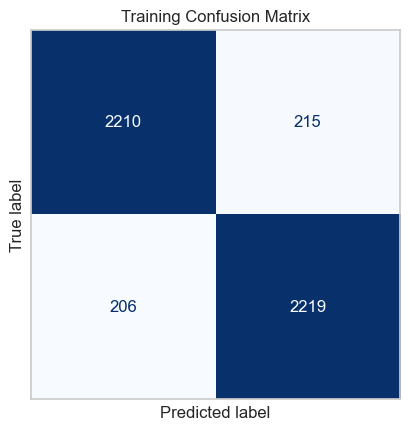

In [19]:
# Now that we have done the legwork, we can produce the desired confusion matrices.

cm_train = confusion_matrix(y_train, prediction_train)

# Set up ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=np.unique(y_train))
disp.plot(cmap='Blues', values_format='d', colorbar=False)

plt.title('Training Confusion Matrix')
plt.xticks([])
plt.yticks([])
plt.show()

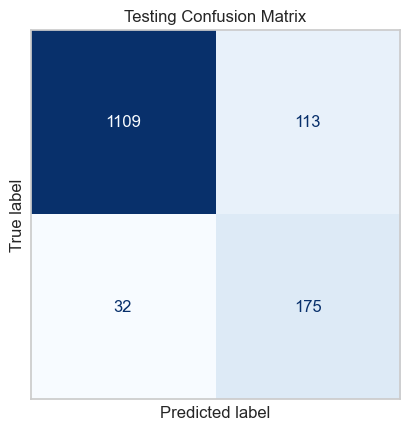

In [20]:
cm_test = confusion_matrix(y_test, prediction_test)

# Set up ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='d', colorbar=False)

plt.title('Testing Confusion Matrix')
plt.xticks([])
plt.yticks([])
plt.show()

In [21]:
FP = cm_test[0,1]
TN = cm_test[0,0]

FPR = FP/ (FP+TN)

print('FPR: ', round(FPR*100,2))


FN = cm_test[1,0]
TP = cm_test[1,1]

FNR = FN/ (FN+TP)

print('FNR: ', round(FNR*100,2))


FPR:  9.25
FNR:  15.46


In [22]:
# Classification_report() has two required fields: the ground truth (y) and the binary predicted values (pred)

print('training performance:', '\n', classification_report(y_train,prediction_train))

print('test performance:', '\n',  classification_report(y_test,prediction_test))

training performance: 
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      2425
           1       0.91      0.92      0.91      2425

    accuracy                           0.91      4850
   macro avg       0.91      0.91      0.91      4850
weighted avg       0.91      0.91      0.91      4850

test performance: 
               precision    recall  f1-score   support

           0       0.97      0.91      0.94      1222
           1       0.61      0.85      0.71       207

    accuracy                           0.90      1429
   macro avg       0.79      0.88      0.82      1429
weighted avg       0.92      0.90      0.91      1429



In [23]:
# First we use sklearn's roc_auc_score() function to find the area under the curve for our initial model.
# Having calculated this value, we can then plot in on a graph along with our ROC curve.

train_auc=roc_auc_score(y_train,y_pred_train)
print(train_auc)


test_auc=roc_auc_score(y_test,y_pred_test)
print(test_auc)

0.9736791582527367
0.9503190303375317


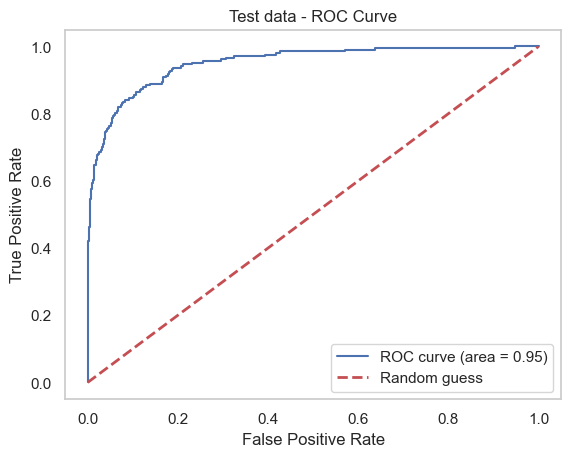

In [24]:
fpr, tpr, thresholds = roc_curve(y_test,  y_pred_test)

# Create ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %test_auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('ROC curve')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend()
plt.title('Test data - ROC Curve')
plt.show()

## Value Prediction

Test impact of top initiative: Increase WorkLifeBalance by 0.3

In [25]:
# Current model
print(log_reg_ext.summary())

                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 4850
Model:                          Logit   Df Residuals:                     4837
Method:                           MLE   Df Model:                           12
Date:                Thu, 11 Jan 2024   Pseudo R-squ.:                  0.7005
Time:                        12:32:17   Log-Likelihood:                -1006.8
converged:                       True   LL-Null:                       -3361.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0527      0.058     -0.908      0.364      -0.166       0.061
WorkLifeBalance            -2.1666      0.084    -25.654      0.000      -2.332      -2.001


## What about a 3% increase in percent salary hike? up to 25% max()

## Cost Savings

Increase in worklife balance is best, otherwise a 3 percent increase in salary hike.

3965 Employees, Aquisition Cost per Employee 30000 (50 - 75% of a full-time annual salary)

In [26]:
y_test.value_counts()

Attrition
0    1222
1     207
Name: count, dtype: int64

In [27]:
y_test.value_counts()[1] / y_test.value_counts()[0]

0.16939443535188217

In [28]:
y_pred_test.mean()

0.23090596410964

In [29]:
y_pred_test.round().value_counts()

0.0    1141
1.0     288
Name: count, dtype: int64

In [30]:
y_pred_test.round().value_counts()[1] / y_pred_test.round().value_counts()[0]

0.25241016652059595

In [31]:
y_pred_test.mean()

0.23090596410964

In [32]:
# Mean (original) values
means = X_test_std.mean().values

In [33]:
# Coefficients
coefs = log_reg_ext.params.values

In [34]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def get_proba_from_log_odds(means, coefs):

    # Model output
    log_odds = (coefs*means).sum()

    return sigmoid(log_odds) * 100

get_proba_from_log_odds(means, coefs)

6.322855090280455

In [35]:
# Add change in worklife + 0.3

features = ['WorkLifeBalance', 'PercentSalaryHike', 'JobSatisfaction', 'EnvironmentSatisfaction', 'TotalWorkingYears', 'Age', 'YearsWithCurrManager',
'YearsAtCompany', 'TrainingTimesLastYear', 'YearsSinceLastPromotion', 'MonthlyIncome', 'DistanceFromHome']
new_values = test[features].mean()
new_values['WorkLifeBalance'] = new_values['WorkLifeBalance'] + 0.3


In [36]:
new_values

WorkLifeBalance                3.329391
PercentSalaryHike             14.404479
JobSatisfaction                3.089573
EnvironmentSatisfaction        2.988803
TotalWorkingYears             11.302309
Age                           36.907628
YearsWithCurrManager           4.153954
YearsAtCompany                 7.121064
TrainingTimesLastYear          2.732680
YearsSinceLastPromotion        2.191742
MonthlyIncome              64970.188943
DistanceFromHome               7.999300
dtype: float64

In [37]:
test[features].mean()

WorkLifeBalance                3.029391
PercentSalaryHike             14.404479
JobSatisfaction                3.089573
EnvironmentSatisfaction        2.988803
TotalWorkingYears             11.302309
Age                           36.907628
YearsWithCurrManager           4.153954
YearsAtCompany                 7.121064
TrainingTimesLastYear          2.732680
YearsSinceLastPromotion        2.191742
MonthlyIncome              64970.188943
DistanceFromHome               7.999300
dtype: float64

In [38]:
# scale
new_means = scaler.transform(new_values.values.reshape(1,-1)).values

/opt/homebrew/Caskroom/miniforge/base/envs/acme/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [39]:
new_means = np.append(1,new_means)

In [40]:
# New values
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def get_proba_from_log_odds(means, coefs):

    # Model output
    log_odds = np.dot(coefs,means)


    return sigmoid(log_odds)

new_prob = get_proba_from_log_odds(new_means, coefs)

In [41]:
old_prob = get_proba_from_log_odds(means, coefs)

In [42]:
(old_prob, new_prob)

(0.06322855090280455, 0.033784762431754746)

In [43]:
# Diff 
old_prob - new_prob

0.029443788471049802

A 3% reduction in turnover...savings?

In [44]:
num_employees_test_case = len(test)

Old_turnover = old_prob*num_employees_test_case

New_turnover = new_prob*num_employees_test_case


employees_retained = Old_turnover - New_turnover
Aquisition_cost_per_employee = 30000

Savings = employees_retained * Aquisition_cost_per_employee

print(Old_turnover, New_turnover, employees_retained, Savings)

90.3535992401077 48.278425514977535 42.07517372513016 1262255.2117539048


## Tests

In [45]:
features = ['const', 'WorkLifeBalance', 'PercentSalaryHike', 'JobSatisfaction', 'EnvironmentSatisfaction', 'TotalWorkingYears', 'Age', 'YearsWithCurrManager',
    'YearsAtCompany', 'TrainingTimesLastYear', 'YearsSinceLastPromotion', 'MonthlyIncome', 'DistanceFromHome']

log_reg_ext_no_const = sm.Logit(y_train, X_train_std[features]).fit()
print(log_reg_ext_no_const.summary())

Optimization terminated successfully.
         Current function value: 0.207585
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 4850
Model:                          Logit   Df Residuals:                     4837
Method:                           MLE   Df Model:                           12
Date:                Thu, 11 Jan 2024   Pseudo R-squ.:                  0.7005
Time:                        12:32:17   Log-Likelihood:                -1006.8
converged:                       True   LL-Null:                       -3361.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0527      0.058     -0.908      0.364      -0.166   

In [46]:
X_test = test.drop(columns = 'Attrition')
y_test = test['Attrition']

features = ['WorkLifeBalance', 'PercentSalaryHike', 'JobSatisfaction', 'EnvironmentSatisfaction', 'TotalWorkingYears', 'Age', 'YearsWithCurrManager',
    'YearsAtCompany', 'TrainingTimesLastYear', 'YearsSinceLastPromotion', 'MonthlyIncome', 'DistanceFromHome']

X_test_std = scaler.transform(X_test[features])
X_test_std  = sm.add_constant(X_test_std)

X_test_std


,const,WorkLifeBalance,PercentSalaryHike,JobSatisfaction,EnvironmentSatisfaction,TotalWorkingYears,Age,YearsWithCurrManager,YearsAtCompany,TrainingTimesLastYear,YearsSinceLastPromotion,MonthlyIncome,DistanceFromHome
0,1.0,1.460027,0.305281,-0.852319,1.277858,-0.287691,0.140132,-1.052884,-0.884216,0.269977,-0.673786,-0.938987,0.616167
1,1.0,0.448161,1.838005,0.193042,1.277858,-0.015992,-0.521103,1.349180,0.516608,-0.569374,1.678160,-0.943399,-1.032647
2,1.0,0.448161,2.494887,0.193042,1.277858,-0.015992,-0.741514,1.349180,0.691711,-1.408724,-0.673786,-0.905014,1.503991
3,1.0,0.448161,2.275926,-0.852319,0.327164,2.429305,1.572806,0.748664,0.691711,-0.569374,-0.337793,0.738260,-0.398487
4,1.0,-0.563705,0.086320,-0.852319,0.327164,-0.287691,-1.072131,1.048922,0.341505,1.948677,1.006176,-0.318430,0.616167
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1424,1.0,1.460027,0.524241,1.238402,1.277858,-0.695240,-0.080280,-0.152110,-0.183804,-0.569374,-0.673786,0.707155,0.489336
1425,1.0,1.460027,1.181123,0.193042,-1.574223,-0.695240,-0.961926,-1.052884,-0.884216,-0.569374,-0.673786,-0.324166,-0.905815
1426,1.0,0.448161,1.400084,0.193042,1.277858,1.342506,1.572806,1.349180,2.442742,-0.569374,0.334191,-0.186951,-0.652151
1427,1.0,0.448161,0.524241,1.238402,-0.623530,2.565154,1.683012,4.051503,2.442742,-2.248074,0.670183,0.687962,0.489336


In [47]:
y_pred_test = log_reg_ext_no_const.predict(X_test_std)
sigmoid(y_pred_test).mean()


0.5549125451216973

In [48]:
def get_proba_from_log_odds_with_intercept(means, coefs, intercept):
    log_odds = np.dot(coefs, means) + intercept
    return sigmoid(log_odds)

intercept = log_reg_ext.params['const']

In [49]:
np.mean(X_test_std, axis =0)

const                      1.000000
WorkLifeBalance            0.477901
PercentSalaryHike          0.393846
JobSatisfaction            0.286678
EnvironmentSatisfaction    0.316520
TotalWorkingYears          0.160927
Age                        0.129952
YearsWithCurrManager       0.194374
YearsAtCompany             0.187601
TrainingTimesLastYear      0.045602
YearsSinceLastPromotion    0.062623
MonthlyIncome              0.038951
DistanceFromHome          -0.144912
dtype: float64

In [50]:
# Mean values
means = X_test_std.mean().values
# Coefficients
coefs = log_reg_ext.params.values
linear_combination = np.dot(coefs, means)
linear_combination

-2.695683380833

In [51]:
sigmoid(linear_combination)

0.06322855090280455

In [52]:
new_prob = get_proba_from_log_odds_with_intercept(new_means[1:], coefs[1:], intercept)
new_prob

0.033784762431754746